# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Reusable Function
Used to check and fix target variable issues

In [2]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.api as sm

def handle_target_variable(y_train, y_test, X_train_preprocessed):
  y_train_updated = y_train
  y_test_updated = y_test
  ##########################################Check for Skeweness##########################################
  # Calculate skewness
  skewness = skew(y_train)
  print(f"Skewness: {skewness:.2f}")

  # Interpret Skewness
  if skewness > 1:
      print("Highly Right-Skewed (Apply log or Box-Cox Transformation)")
      # Log Transformation (for positive values)
      y_train_updated = np.log1p(y_train)
      y_test_updated = np.log1p(y_test)
      # OR
      # Box-Cox Transformation (only for strictly positive values)
      #y_train_updated = PowerTransformer(method='box-cox').fit_transform(y_train_updated.reshape(-1,1))
      #y_test_updated = PowerTransformer(method='box-cox').fit_transform(y_test_updated.reshape(-1,1))
  elif skewness < -1:
      print("Highly Left-Skewed (Apply square or Yeo-Johnson Transformation)")
      # Yeo-Johnson Transformation (works with negative values)
      y_train_updated = PowerTransformer(method='yeo-johnson').fit_transform(y_train_updated.reshape(-1,1))
      y_test_updated = PowerTransformer(method='yeo-johnson').fit_transform(y_test_updated.reshape(-1,1))
  else:
      print("Approximately Normal Distribution (No transformation needed)")
  ##########################################Check for Skeweness##########################################

  ##########################################Detecting Outliers in Target Variable##########################################
  # Calculate IQR (Interquartile Range)
  Q1 = np.percentile(y_train_updated, 25)
  Q3 = np.percentile(y_train_updated, 75)
  IQR = Q3 - Q1

  # Define bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Find outliers
  outliers = (y_train_updated < lower_bound) | (y_train_updated > upper_bound)
  print(f"Number of outliers: {outliers.sum()}")

  # Handle Outliers in Target Variable if Exist
  if ((y_train_updated < lower_bound).sum() > 0) or ((y_train_updated > upper_bound).sum() > 0):
      print("Handling Outliers in Target Variable")
      inliers = ~outliers
      y_train_updated = y_train_updated[inliers]
      X_train_preprocessed = X_train_preprocessed[inliers]  # Keep only corresponding rows
  ##########################################Detecting Outliers in Target Variable##########################################

  ##########################################Checking Homoscedasticity##########################################
  # Fit a linear regression model
  model = LinearRegression()
  model.fit(X_train_preprocessed, y_train_updated)
  y_pred = model.predict(X_train_preprocessed)

  # Compute residuals
  residuals = y_train_updated - y_pred

  if not isinstance(X_train_preprocessed, np.ndarray):
    X_train_preprocessed_array = X_train_preprocessed.toarray()
  else:
    X_train_preprocessed_array = X_train_preprocessed

  # Perform Goldfeld-Quandt test
  gq_test = het_goldfeldquandt(residuals, X_train_preprocessed_array)
  p_value = gq_test[1]
  print(f"Goldfeld-Quandt p-value: {p_value:.4f}")

  if p_value < 0.05:
      print("Significant heteroscedasticity detected (p < 0.05)")

      # Log Transform the Target Variable
      y_train_updated = np.log1p(y_train_updated)
      y_test_updated = np.log1p(y_test_updated)  # Apply to test for consistency

      # Refit Model with Log-Transformed Target
      model = LinearRegression()
      model.fit(X_train_preprocessed, y_train_updated)
      y_pred_log = model.predict(X_train_preprocessed)

      # Use Weighted Least Squares (WLS) Regression
      weights = 1 / (y_pred_log ** 2)  # Inverse variance weighting
      model_wls = sm.WLS(y_train_updated, sm.add_constant(X_train_preprocessed), weights=weights)
      results = model_wls.fit()
      print(results.summary())
  else:
      print("No significant heteroscedasticity detected")
  ##########################################Checking Homoscedasticity##########################################
  return y_train_updated, y_test_updated, X_train_preprocessed

# Load Dataset


In [3]:
df = pd.read_csv("Datasets/car_price_dataset.csv")
df.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [ ]:
df.describe()

In [ ]:
df.info()

# Preprocessing

In [4]:
current_year = 2025
df['Car_Age'] = current_year - df['Year']
X = df.drop(columns=['Price', 'Year'])
y = df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

In [5]:
num_features = X.select_dtypes(exclude=['object']).columns.to_list()
cat_features = X.select_dtypes(include=['object']).columns.to_list()

print(f"Numerical Features: {num_features}")
print(f"Categorical Features: {cat_features}")

Numerical Features: ['Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Car_Age']
Categorical Features: ['Brand', 'Model', 'Fuel_Type', 'Transmission']


#### 1) Handling Missing Values

In [ ]:
print(f"X_train Missing Values %:\n {X_train.isnull().sum() * 100 / len(X_train)}")
print(f"X_test Missing Values %:\n {X_test.isnull().sum() * 100 / len(X_test)}")

#### 2) Handling Outliers

Number of outliers for features (Engine_Size): 0
Number of outliers for features (Mileage): 0
Number of outliers for features (Doors): 0
Number of outliers for features (Owner_Count): 0
Number of outliers for features (Car_Age): 0


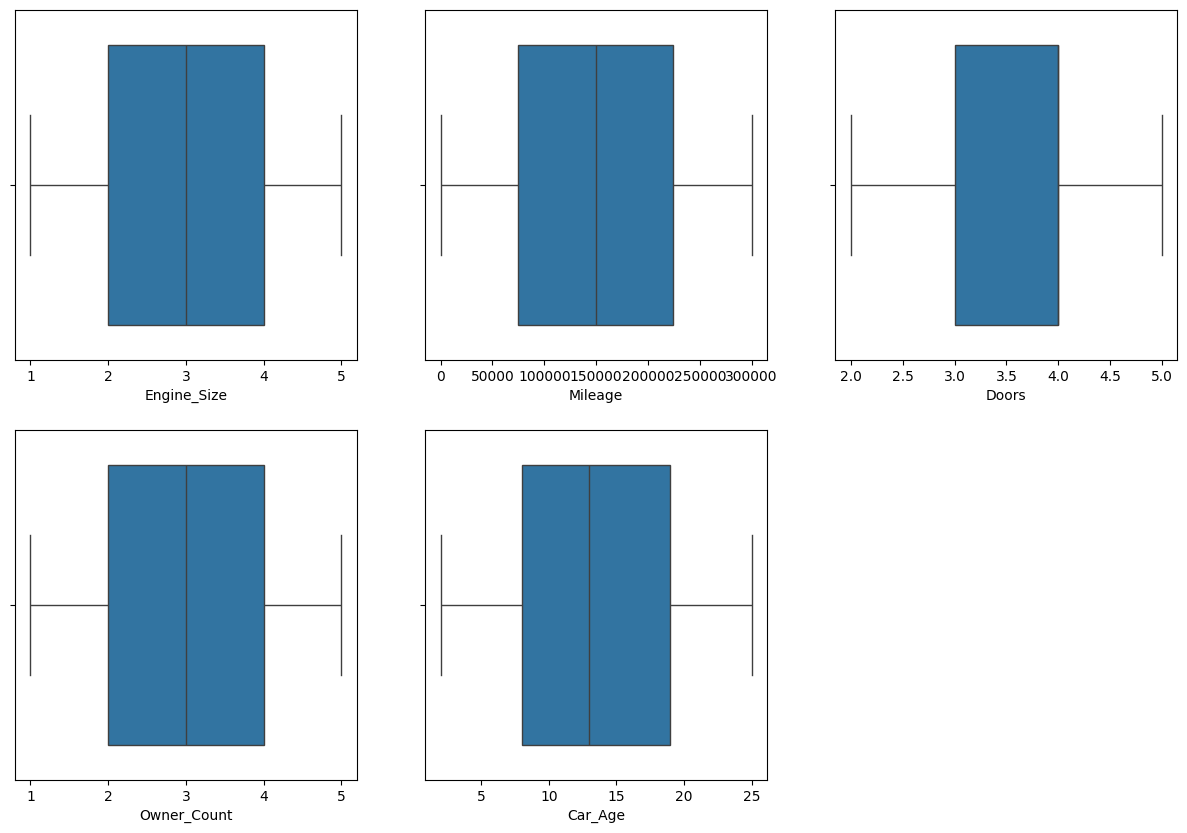

In [6]:
plt.figure(figsize=(15,10))
for i,col in enumerate(num_features):
  plt.subplot(2,3,i+1)
  # Boxplot for outlier detection
  sns.boxplot(x=X_train[col])

  # IQR method
  Q1 = np.percentile(X_train[col], 25)
  Q3 = np.percentile(X_train[col], 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Detect outliers
  outliers = (X_train[col] < lower_bound) | (X_train[col] > upper_bound)
  print(f"Number of outliers for features ({col}): {outliers.sum()}")

  # if outliers exist
  if outliers.sum() > 0:
    # Option 1: Remove Outliers
    mask = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
    # Apply mask to both X_train and y_train
    #X_train = X_train[mask]
    #y_train = y_train[mask]  # Remove corresponding target values

    # Option 2: Cap Outliers
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)

#### 3) Dealing with categorical features
Encoding either with:

*   **OneHotEncoder:** when categories are nominal (Ex: [red, blue, green])
*   **LabelEncoder:** when categoirs are ordinal (Ex: [Bachelor's, Matser's, PhD])



In [7]:
# All categorical features are Nominal so we will apply OneHotEncoder
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

#### 4) Feature Scaling
Numerical Features are scaled with:


*   **StandardScaler** if the feature follows a Normal Distribution
*   **MinMaxScaler** otherwise



In [8]:
from scipy.stats import shapiro

gaussian_features = []
non_gaussian_features = []
for col in num_features:
    stat, p = shapiro(X_train[col])
    if p > 0.05:
        gaussian_features.append(col)
    else:
        non_gaussian_features.append(col)

print(f"Gaussian Features: {gaussian_features}")
print(f"Non-Gaussian Features: {non_gaussian_features}")

# For Gaussian Distributed Features we apply StandardScaler
# For Non Gaussian Distributed Features we apply MinMaxScaler
# All features are Non Gaussian Distributes so we will use MinMaxScaler
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

Gaussian Features: []
Non-Gaussian Features: ['Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Car_Age']


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8000.
  res = hypotest_fun_out(*samples, **kwds)


#### 5) Feature Engineering - Data Transformation
Numerical Features are transormed with:


*   **Log Transformation** if the feature is skewed (skewness>1)
*   **Polynomial Features** if low skewness and non-linear relationship



In [ ]:
from scipy.stats import skew

skewed_features = [col for col in num_features if abs(skew(X_train[col])) > 1]
non_skewed_features = [col for col in num_features if col not in skewed_features]

print(f"Skewed Features: {skewed_features}")
print(f"Non-Skewed Features: {non_skewed_features}")

# For Skewed Features we apply Log Transformation
# For Non Skewed we apply Polynomial
# All features are non skewed so we apply Polynomial
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Prepare the Preprocessor

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#### 5) Target Variable Issues

In [10]:
y_train_updated = y_train
y_test_updated = y_test

#### 5.A) Checking Target Variable Distribution (Skewness)

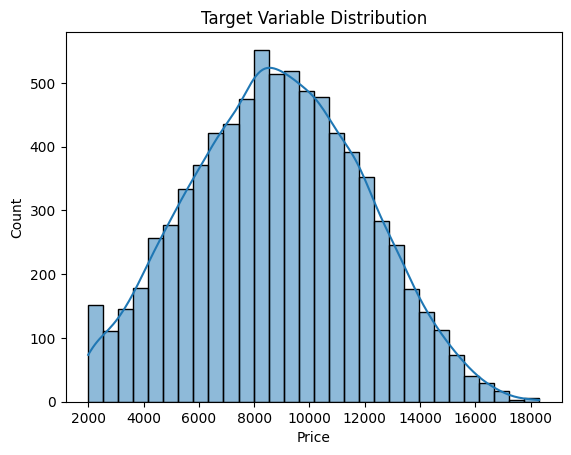

Skewness: 0.03
Approximately Normal Distribution (No transformation needed)


In [11]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

# Plot histogram of the target variable
sns.histplot(y_train, bins=30, kde=True)
plt.title("Target Variable Distribution")
plt.show()

# Calculate skewness
skewness = skew(y_train)
print(f"Skewness: {skewness:.2f}")

# Interpret Skewness
if skewness > 1:
    print("Highly Right-Skewed (Apply log or Box-Cox Transformation)")
    # Log Transformation (for positive values)
    y_train_updated = np.log1p(y_train)
    y_test_updated = np.log1p(y_test)
    # OR
    # Box-Cox Transformation (only for strictly positive values)
    #y_train_updated = PowerTransformer(method='box-cox').fit_transform(y_train.reshape(-1,1))
    #y_test_updated = PowerTransformer(method='box-cox').fit_transform(y_test.reshape(-1,1))
elif skewness < -1:
    print("Highly Left-Skewed (Apply square or Yeo-Johnson Transformation)")
    # Yeo-Johnson Transformation (works with negative values)
    y_train_updated = PowerTransformer(method='yeo-johnson').fit_transform(y_train.reshape(-1,1))
    y_test_updated = PowerTransformer(method='yeo-johnson').fit_transform(y_test.reshape(-1,1))
else:
    print("Approximately Normal Distribution (No transformation needed)")

#### 5.B) Detecting and Handling Outliers in Target Variable

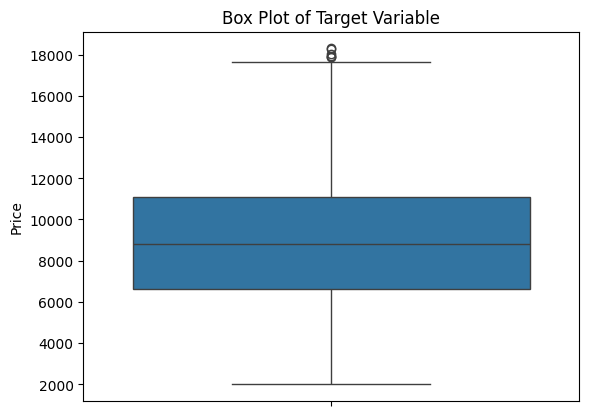

Number of outliers: 6
Number of outliers (Z-score method): 2
Handling Outliers in Target Variable


In [12]:
# Boxplot to visualize outliers
sns.boxplot(y=y_train_updated)
plt.title("Box Plot of Target Variable")
plt.show()

# Calculate IQR (Interquartile Range)
Q1 = np.percentile(y_train_updated, 25)
Q3 = np.percentile(y_train_updated, 75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = (y_train_updated < lower_bound) | (y_train_updated > upper_bound)
print(f"Number of outliers: {outliers.sum()}")

# Detect outliers using Z-score
from scipy.stats import zscore
z_scores = zscore(y_train_updated)
outliers_z = np.abs(z_scores) > 3
print(f"Number of outliers (Z-score method): {outliers_z.sum()}")

# Handle Outliers in Target Variable if Exist
if ((y_train_updated < lower_bound).sum() > 0) or ((y_train_updated > upper_bound).sum() > 0):
    print("Handling Outliers in Target Variable")
    inliers = ~outliers
    y_train_updated = y_train_updated[inliers]
    X_train_preprocessed = X_train_preprocessed[inliers]  # Keep only corresponding rows

#### 5.C) Checking Homoscedasticity (Constant Variance of Errors)

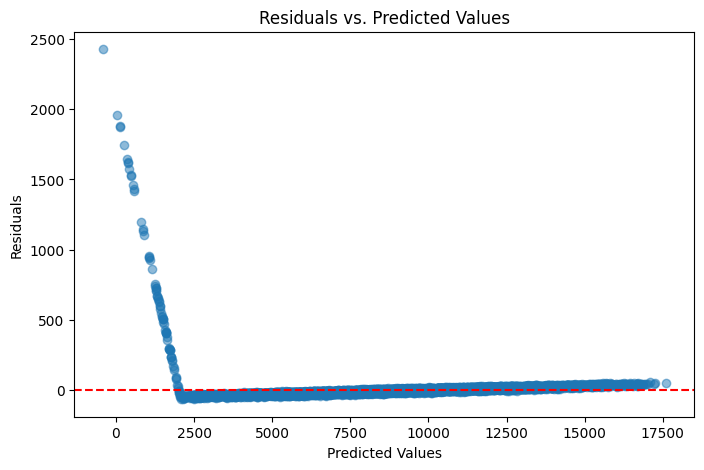

In [13]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train_preprocessed, y_train_updated)
y_pred = model.predict(X_train_preprocessed)

# Compute residuals
residuals = y_train_updated - y_pred

# Plot residuals vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

In [14]:
if not isinstance(X_train_preprocessed, np.ndarray):
    X_train_preprocessed_array = X_train_preprocessed.toarray()
else:
    X_train_preprocessed_array = X_train_preprocessed

# Perform Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, X_train_preprocessed_array)
p_value = gq_test[1]
print(f"Goldfeld-Quandt p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant heteroscedasticity detected (p < 0.05)")

    # Log Transform the Target Variable
    y_train_updated = np.log1p(y_train_updated)
    y_test_updated = np.log1p(y_test_updated)  # Apply to test for consistency

    # Refit Model with Log-Transformed Target
    model = LinearRegression()
    model.fit(X_train_preprocessed, y_train_updated)
    y_pred_log = model.predict(X_train_preprocessed)

    # Use Weighted Least Squares (WLS) Regression
    weights = 1 / (y_pred_log ** 2)  # Inverse variance weighting
    model_wls = sm.WLS(y_train_updated, sm.add_constant(X_train_preprocessed), weights=weights)
    results = model_wls.fit()
    print(results.summary())
else:
    print("No significant heteroscedasticity detected")

Goldfeld-Quandt p-value: 1.0000
No significant heteroscedasticity detected


# Model Training

In [15]:
# Pipeline with preprocessor and LinearRegression model
model = LinearRegression()
# Fit the model
model.fit(X_train_preprocessed, y_train_updated)

LinearRegression()

# Predictions

In [16]:
# Predict Prices
y_pred = model.predict(X_test_preprocessed)

# Compare actual vs predicted
df_results = pd.DataFrame({'Actual': y_test_updated, "Predicted": y_pred})
df_results.head()

,Actual,Predicted
6252,2000,1691.649458
4684,11164,11148.952207
1731,14630,14601.633064
4742,7334,7349.001575
4521,10127,10146.116097


# Model Evaluation

In [17]:
mae = mean_absolute_error(y_test_updated, y_pred)
mse = mean_squared_error(y_test_updated, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_updated, y_pred)

print(f"Mean Absolute Error: {mae: .2f}")
print(f"Mean Squared Error: {mse: .2f}")
print(f"Root Mean Squared Error: {rmse: .2f}")
print(f"R^2 Score: {r2: .4f}")

Mean Absolute Error:  20.07
Mean Squared Error:  4214.92
Root Mean Squared Error:  64.92
R^2 Score:  0.9995


# Visualize Predictions

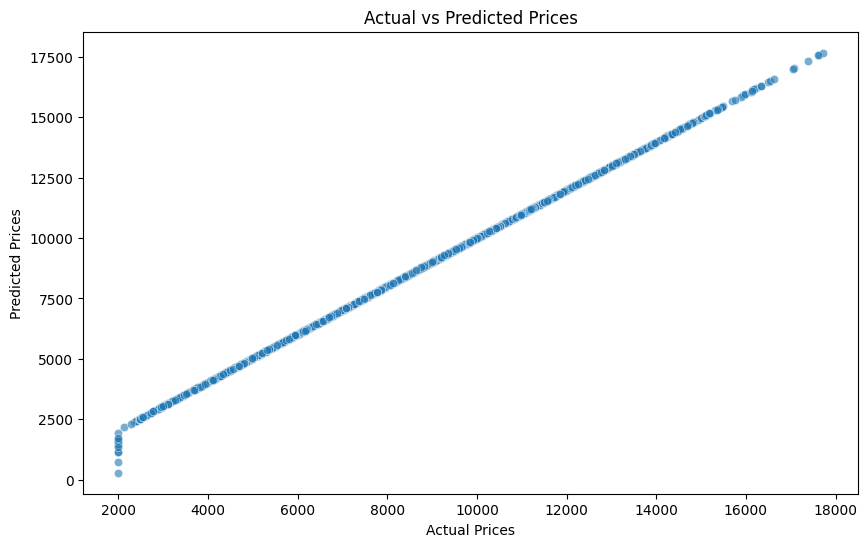

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test_updated, y=y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

# Improving Linear Regression

1.   **Feature Engineering:** Adding new features
2.   **Polynomial Regression:** Adding non-linearity
3.   **Regularization:** Ridge and Lasso Regression





#### Polynomial Regression



In [19]:
from scipy.stats import skew

skewed_features = [col for col in num_features if abs(skew(X_train[col])) > 1]
non_skewed_features = [col for col in num_features if col not in skewed_features]

print(f"Skewed Features: {skewed_features}")
print(f"Non-Skewed Features: {non_skewed_features}")

# For Skewed Features we apply Log Transformation
# For Non Skewed we apply Polynomial
# All features are non skewed so we apply Polynomial
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

Skewed Features: []
Non-Skewed Features: ['Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Car_Age']


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_updated, y_test_updated, X_train_preprocessed = handle_target_variable(y_train, y_test, X_train_preprocessed)

Skewness: 0.03
Approximately Normal Distribution (No transformation needed)
Number of outliers: 6
Handling Outliers in Target Variable
Goldfeld-Quandt p-value: 1.0000
No significant heteroscedasticity detected


In [21]:
# LinearRegression model
poly_model =  LinearRegression()

# Fit the model
poly_model.fit(X_train_preprocessed, y_train_updated)

LinearRegression()

In [22]:
# Predict Prices
poly_y_pred = poly_model.predict(X_test_preprocessed)

# Compare actual vs predicted
df_results = pd.DataFrame({'Actual': y_test_updated, "Predicted": poly_y_pred})
df_results.head()

,Actual,Predicted
6252,2000,1767.226915
4684,11164,11127.913240
1731,14630,14660.786297
4742,7334,7326.032089
4521,10127,10120.665692


#### Regularization-Ridge


In [23]:
preprocessor = ColumnTransformer(
    transformers=[
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_updated, y_test_updated, X_train_preprocessed = handle_target_variable(y_train, y_test, X_train_preprocessed)

Skewness: 0.03
Approximately Normal Distribution (No transformation needed)
Number of outliers: 6
Handling Outliers in Target Variable
Goldfeld-Quandt p-value: 1.0000
No significant heteroscedasticity detected


In [24]:
ridge_model = Ridge(alpha=10)

# Fit the model
ridge_model.fit(X_train_preprocessed, y_train_updated)

Ridge(alpha=10)

In [25]:
# Predict Prices
ridge_y_pred = ridge_model.predict(X_test_preprocessed)

# Compare actual vs predicted
df_results = pd.DataFrame({'Actual': y_test_updated, "Predicted": ridge_y_pred})
df_results.head()

,Actual,Predicted
6252,2000,1579.192501
4684,11164,11200.048329
1731,14630,14821.439334
4742,7334,7440.698397
4521,10127,10137.364071


#### Regularization-Lasso

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
                    ('num', num_pipeline, num_features),
                    ('cat', cat_pipeline, cat_features)
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_updated, y_test_updated, X_train_preprocessed = handle_target_variable(y_train, y_test, X_train_preprocessed)

Skewness: 0.03
Approximately Normal Distribution (No transformation needed)
Number of outliers: 6
Handling Outliers in Target Variable
Goldfeld-Quandt p-value: 1.0000
No significant heteroscedasticity detected


In [27]:
lasso_model = Lasso(alpha=10)

# Fit the model
lasso_model.fit(X_train_preprocessed, y_train_updated)

Lasso(alpha=10)

In [28]:
# Predict Prices
lasso_y_pred = lasso_model.predict(X_test_preprocessed)

# Compare actual vs predicted
df_results = pd.DataFrame({'Actual': y_test_updated, "Predicted": lasso_y_pred})
df_results.head()

,Actual,Predicted
6252,2000,1902.756595
4684,11164,11032.941429
1731,14630,14395.520711
4742,7334,7407.125864
4521,10127,10116.194852


# Imporved Models Evaluation

In [29]:
poly_r2 = r2_score(y_test_updated, poly_y_pred)
ridge_r2 = r2_score(y_test_updated, ridge_y_pred)
lasso_r2 = r2_score(y_test_updated, lasso_y_pred)

print(f"Polynomial Features Model R^2 Score: {poly_r2: .4f}")
print(f"Ridge R^2 Score: {ridge_r2: .4f}")
print(f"Lasso R^2 Score: {lasso_r2: .4f}")

Polynomial Features Model R^2 Score:  0.9996
Ridge R^2 Score:  0.9975
Lasso R^2 Score:  0.9988


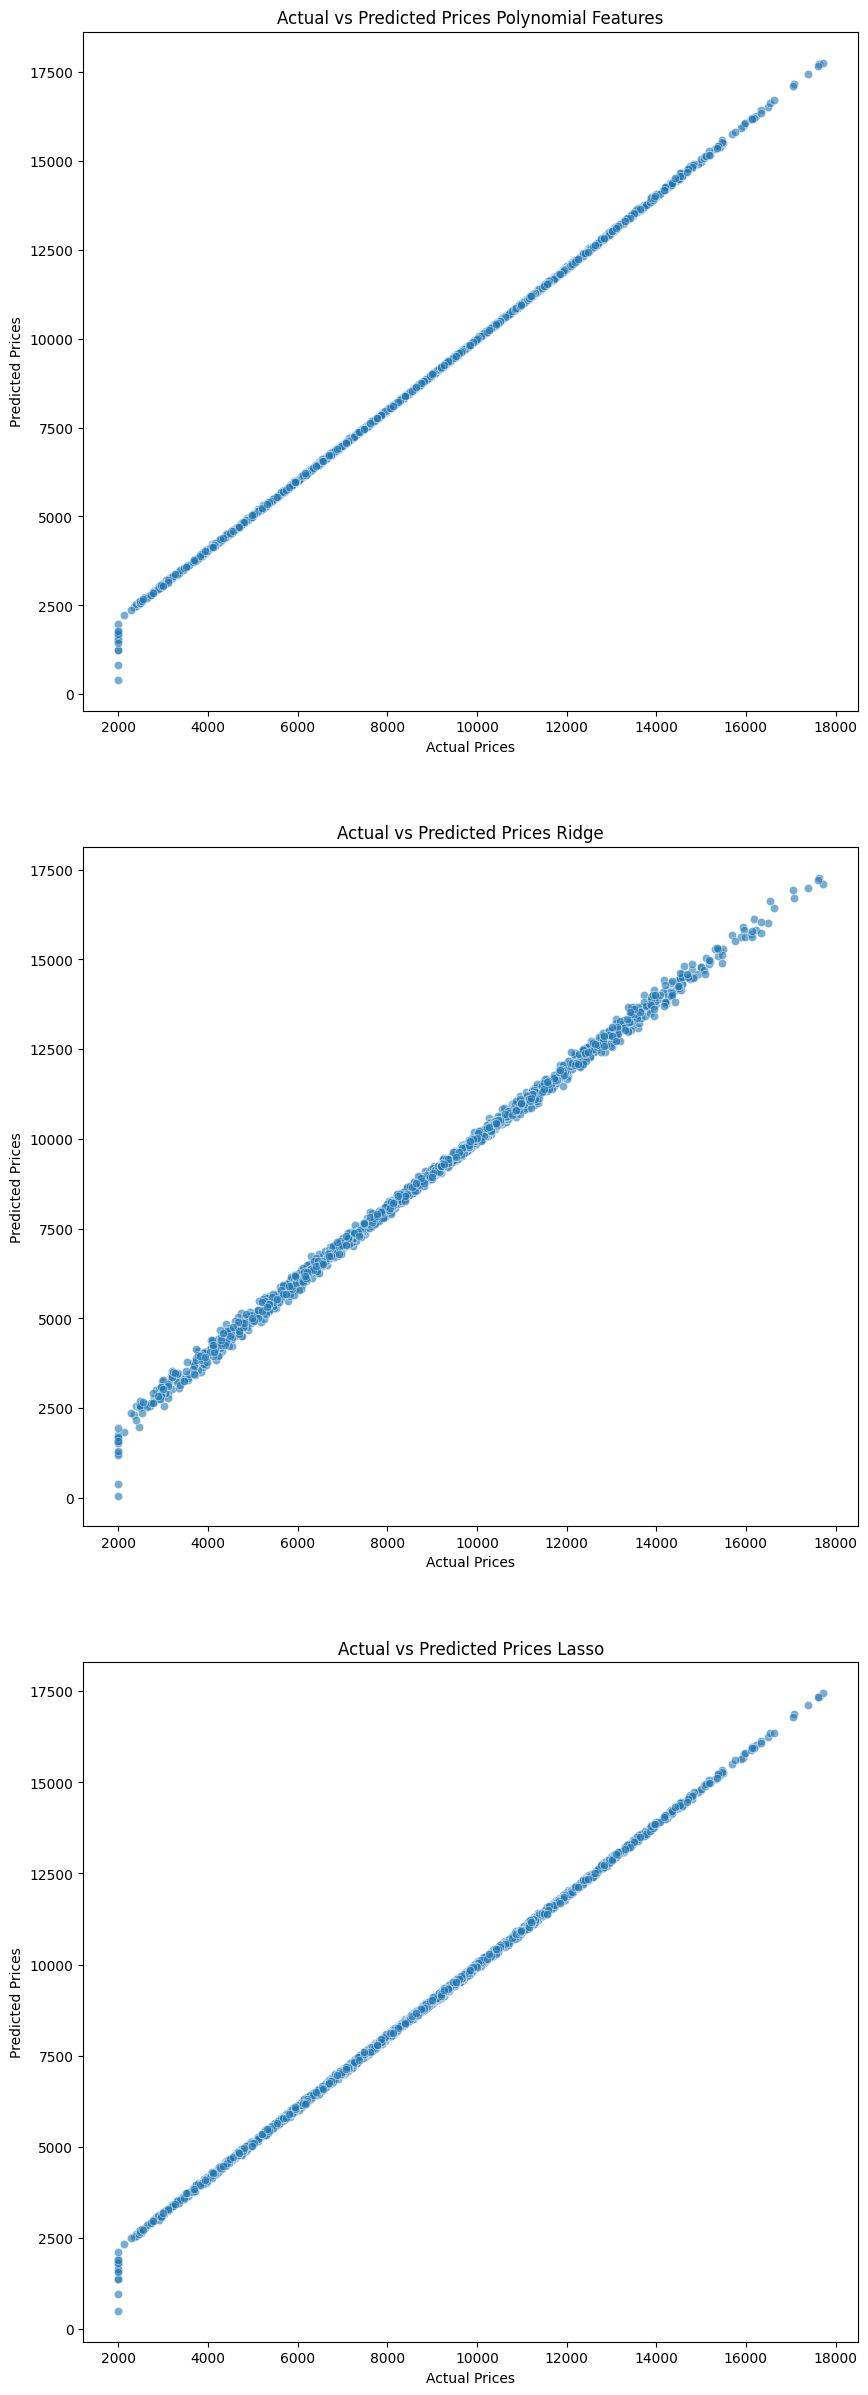

In [30]:
y_pred_arr = [poly_y_pred, ridge_y_pred, lasso_y_pred]
models = ["Polynomial Features", "Ridge", "Lasso"]
plt.figure(figsize=(10,30))
for i in range(3):
  plt.subplot(3,1,i+1)
  sns.scatterplot(x=y_test_updated, y=y_pred_arr[i], alpha=0.6)
  plt.xlabel("Actual Prices")
  plt.ylabel("Predicted Prices")
  plt.title(f"Actual vs Predicted Prices {models[i]}")
plt.show()